## Theory

Given two rate of interest $r_d$ and $r_f$ where $r_d$ and $r_f$ are the domestic and foreign rate of interest. We can price a forward exchange rate contract according to

$$
F^X(0,T) = X_0\frac{B^f(0,T)}{B^d(0,t)}
$$
where $X_0$ is the initial domestic/foreign rate of exchange and, $B^f(0,T)$ and $B^d(0,T)$ are the domestic and foreign zero-coupon bond price at time $T$.

Starting with two independent Ornstein-Uhlenbeck processes to model the stochastic interest rate of the domestic and foreign interest rate;

$$
dr_t^d = \theta^d(\mu^d-r_t^d)dt + \sigma^d dW_t,
$$
$$
dr_t^f = \theta^f(\mu^f-r_t^f)dt + \sigma^f dW_t.
$$

The analytical solution of the SDE is the following;
$$
r_t = r_0e^{-\theta t} + \mu(1-e^{-\theta t}) + \sigma \int_0^t r^{-\theta(t-s)}dW_s
$$

The initial price of a bond at time $t=0$ that expiries at time $t=T$ is given by the following formula;

$$
B(0,T) = \mathbb{E}\left[e^{\left(-\int_0^Tr_sds\right)}\right].
$$

According to the litterature, we can solve this anatyically via PDE which leads to
$$
B(0,T) = \exp\left\{-A(0,T)r_0 + D(0,T)\right\},
$$
where $r_0$ is the rate of interest at time $t=0$
$$
A(0,T) = \frac{1-e^{-\theta T}}{\theta},
$$
$$
D(0,T) = \left(\mu - \frac{\sigma^2}{2\theta^2}\right)\left[A(0,T)-T\right]-\frac{\sigma^2A(0,T)^2}{4\theta}.
$$

See Journal of Applied Mathematics and Decision Sciences, 8(1), 1-14 for reference.

Given initial conditions and parameters of the stochastic process for both domestic and foreign rate of interest, we can find the analytical solution for both bond prices and the forward exchange rate.

## Analytical Functions

In [1]:
def stoc_bond_price(dynamics, contract):
    """
    Function that computes the analytical zero-coupon bond price given ornstein-uhlenbeck short rate stochastic process 
    """
    
    theta, mu, sigma, r0, t = dynamics.theta, dynamics.mu, dynamics.sigma, dynamics.r0, contract.T
    
    A = (1-np.exp(-theta*t))/theta
    D = (mu - (sigma**2)/(2*(theta)**2))*(A-t) - ((sigma**2)*A**2)/(4*theta)
    
    return np.exp(-A*r0+D)

def forward_exchange_rate(X0, dynamics_f, dynamics_d, contract):
    """
    Function that computes the analytical price of a forward exchange rate given the parameters of 2 short rate following ornstein-uhlenbeck SDE 
    """
    
    bond_f = stoc_bond_price(dynamics_f, contract)
    bond_d = stoc_bond_price(dynamics_d, contract)
    
    return X0*bond_f/bond_d

In [2]:
import numpy as np
import bisect as bisect
from scipy import interpolate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd

## Finite Difference Method Dynamics 

In [52]:
# Initialize values for the Dynamics for debugging purposes

class Dynamics:
    pass
domestics_bond = Dynamics()
domestics_bond.r0 = 0.04
domestics_bond.theta = 3
domestics_bond.mu = 0.05
domestics_bond.sigma = 0.08

foreign_bond = Dynamics()
foreign_bond.r0 = 0.10
foreign_bond.theta = 4
foreign_bond.mu = 0.08
foreign_bond.sigma = 0.12

class Contract:
    pass

contract = Contract()
contract.T = 2 

class FD:
    pass

fd_dom = FD()
fd_dom.rMax=0.35
fd_dom.rMin=-0.25
fd_dom.deltar=np.min([domestics_bond.sigma**2,0.05])
fd_dom.deltat=contract.T/10000

fd_for = FD()
fd_for.rMax=0.35
fd_for.rMin=-0.25
fd_for.deltar=np.min([foreign_bond.sigma**2,0.05])
fd_for.deltat=contract.T/10000

Given that 
$$
dr_t = \alpha(r_t,t)dt + \beta(r_t,t)dW_t
$$

We have that 
$$
dC_t = \frac{\partial C}{\partial t}dt + \frac{\partial C}{\partial r} dr_t + \frac{1}{2}\frac{\partial^2 C}{\partial r^2}d<r>_t
$$

$$
= \left[ \frac{\partial C}{\partial t} + \alpha \frac{\partial C}{\partial r} + \frac{1}{2}\beta^2\frac{\partial^2 C}{\partial r^2}\right]dt + \beta \frac{\partial C}{\partial r}dW_t
$$

$$
\frac{\partial C}{\partial t} + \alpha(r_t,t)\frac{\partial C}{\partial r} + \frac{1}{2}\beta(r_t,t)^2\frac{\partial^2 C}{\partial r^2} - r_tC_t = 0 
$$

We are now given that $\alpha(r_t,t) = \theta(\mu - r_t)$ and $\beta(r_t,t) = \sigma$, which leads to the following PDE:

$$
\frac{\partial C}{\partial t} + \left[\theta(\mu - r_t) \right]\frac{\partial C}{\partial r} + \frac{\sigma^2}{2}\frac{\partial^2 C}{\partial r^2} - r_tC = 0
$$

Define $\nu = \theta(\mu - r_t)$ and use the central-difference explicit finite difference scheme to the PDE.

$$
\frac{\partial C}{\partial t} + \nu\frac{\partial C}{\partial r} + \frac{\sigma^2}{2}\frac{\partial^2 C}{\partial r^2} - r_tC = 0
$$

## Intermediate functions

In [4]:
def two_closest(lst, K): 
    """
    Function that find the closest upper and lower element in an array
    """
    
    pos_arr = lst[(lst-K) >0]
    neg_arr = lst[(K-lst) > 0]
    
    min_val = neg_arr[(np.abs(neg_arr - K)).argmin()]
    max_val = pos_arr[(np.abs(pos_arr - K)).argmin()]
    
    return min_val, max_val

def interpolate_rate(r_arr, bondprice, r0):
    """
    Find the interpolate value of a 
    """
    
    r_low, r_high = two_closest(r_arr, r0)
    bond_low = bondprice[np.where(r_arr == r_low)[0][0]]
    bond_high = bondprice[np.where(r_arr == r_high)[0][0]]
    
    x = [r_low, r_high]
    y = [bond_low, bond_high]
    
    f = interpolate.interp1d(x,y)
    
    return f(r0)


## Pricing Functions 

In [5]:
def pricer_bond_vasicek_explicitFD(contract,dynamics,fd):
    
    """
    returns array of all initial short rates,
    and the corresponding array of zero-coupon
    T-maturity bond prices
    """ 

    T = contract.T
    theta, mu, sigma = dynamics.theta, dynamics.mu, dynamics.sigma    
    rMax, rMin, deltar, deltat = fd.rMax, fd.rMin, fd.deltar, fd.deltat    
    N=round(T/deltat)
    if abs(N-T/deltat) > 1e-12:
        raise ValueError("Bad delta t")
        
    r=np.arange(rMax,rMin-deltar/2,-deltar)   
    bondprice=np.ones(np.size(r))
    
    v = theta*(mu-r)
    
    qu=    0.5*((sigma**2*deltat)/(deltar**2)+(v*deltat)/(deltar))
    qd=    0.5*((sigma**2*deltat)/(deltar**2)-(v*deltat)/(deltar))
    qm=    1-qu-qd

    for t in np.arange(N-1,-1,-1)*deltat:
        bondprice=1/(1+r*deltat)*(qd*np.roll(bondprice,-1)+qm*bondprice+qu*np.roll(bondprice,1))
        
        # so let us impose "linearity" boundary conditions
        bondprice[0]=2*bondprice[1]-bondprice[2]
        bondprice[-1]=2*bondprice[-2]-bondprice[-3]
        
    return (r, bondprice)

In [6]:
def price_zero_coupon_vasicek_bond_pde_fd(contract, dynamics, fd):
    """
    Returns the price of the zero-coupon vasicek bond given the contract and dynamics
    """
    
    r, bondprice = pricer_bond_vasicek_explicitFD(contract,dynamics,fd)
    
    return interpolate_rate(r, bondprice, dynamics.r0)

def price_forward_currency_contract_pde_fd(X0, contract, dynamics_f, dynamics_d, fd_f, fd_d):
    """
    Returns the price of forward currency contract for two independent vasicek bond under a contract and dynamics
    """
    
    bond_f = price_zero_coupon_vasicek_bond_pde_fd(contract,dynamics_f,fd_f)
    bond_d = price_zero_coupon_vasicek_bond_pde_fd(contract,dynamics_d,fd_d)
    
    return X0 * bond_f/bond_d

## In this subsection we will compute the forward currency contract price for various value of volatilities and compare it to the analytical result.

In [69]:
N=1000
X0 = 1.3

sigma_f = np.linspace(0.05,0.50, N)
pde_fx_forward = np.zeros(N)
analytical_fx_forward = np.zeros(N)

# Two loops to be able to time the time it takes to solve via the finite-difference method and the analytical solution
for i, sigma in enumerate(tqdm(sigma_f)):
    foreign_bond.sigma = sigma
    
    pde_sol = price_forward_currency_contract_pde_fd(X0, contract, foreign_bond, domestics_bond, fd_for, fd_dom)
    pde_fx_forward[i] = pde_sol


for i, sigma in enumerate(tqdm(sigma_f)):
    foreign_bond.sigma = sigma
    
    analytical_sol = forward_exchange_rate(X0, foreign_bond, domestics_bond, contract)
    analytical_fx_forward[i] = analytical_sol    

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 50130.92it/s]


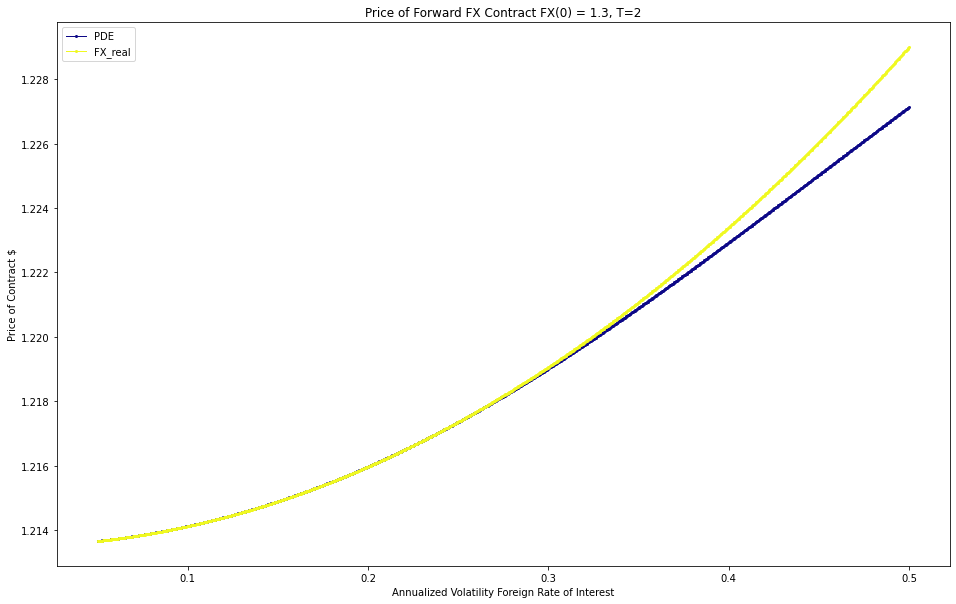

In [75]:
df = pd.DataFrame()
df['Volatility'] = sigma_f
df['PDE'] = pde_fx_forward
df['FX_real'] = analytical_fx_forward
df.set_index('Volatility', inplace = True)

ax = df.plot(lw=1, colormap='plasma', marker='.', markersize=4, title='Price of Forward FX Contract FX(0) = 1.3, T=2', figsize = (16,10))
ax.set_xlabel("Annualized Volatility Foreign Rate of Interest")
ax.set_ylabel("Price of Contract $")
plt.show()

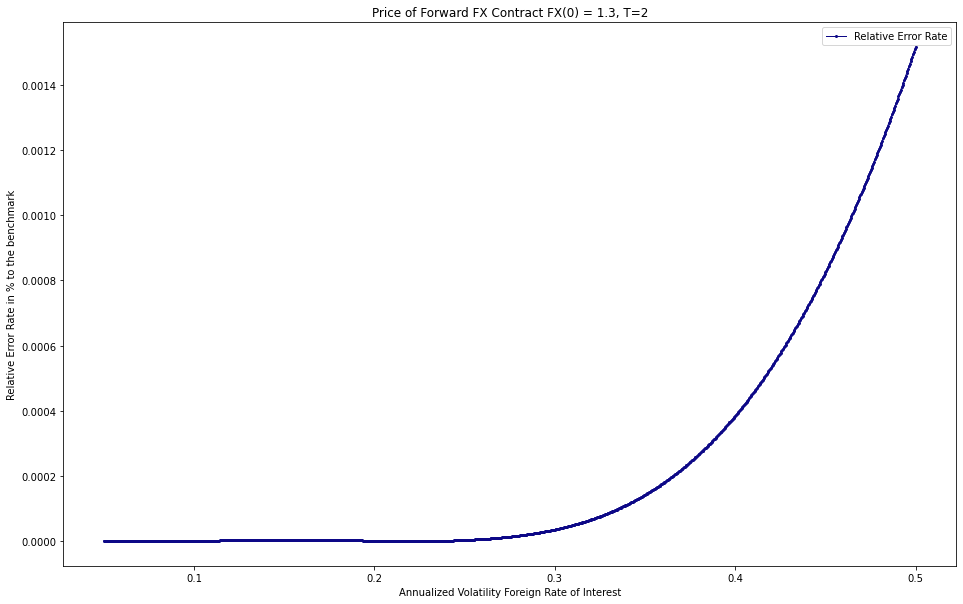

In [76]:
error_rate = (np.abs(pde_fx_forward-analytical_fx_forward))/analytical_fx_forward
df2 = pd.DataFrame()
df2['Volatility'] = sigma_f
df2['Relative Error Rate'] = error_rate
df2.set_index('Volatility', inplace = True)

ax2 = df2.plot(lw=1, colormap='plasma', marker='.', markersize=4, title='Price of Forward FX Contract FX(0) = 1.3, T=2', figsize = (16,10))
ax2.set_xlabel("Annualized Volatility Foreign Rate of Interest")
ax2.set_ylabel("Relative Error Rate in % to the benchmark")
plt.show()